In [1]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import pickle
import mplhep as hep
import math
from tabulate import tabulate
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')
hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})

#### Notebook Parameters
`tag`: _str_, tag used to identify which .pkl files to import. Will select `infile_names` to have `<tag>.pkl`.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>
`infile_names`: _array of str_: full paths of .pkl files.<br>

In [20]:
# parameters
input_label = 'L35Cut'
output_label = '/home/submit/lavezzo/public_html/SUEP/nPVs_l35_njets2_study/'
file_ext = '.png'

# input .pkl files
plotDir = os.getcwd()
infile_all = [plotDir+'/outputs/'+dataset for dataset in os.listdir(plotDir+'/outputs/')]
# some predefined options to choose from
infile_names_2018 = [f for f in infile_all if '20UL18' in f or 'UL2018' in f]
infile_names_2017 = [f for f in infile_all if '20UL17' in f or 'UL2017' in f]
infile_names_2016 = [f for f in infile_all if ('20UL16MiniAODv2' in f or 'UL2016' in f) \
                     and ('HIPM_UL' not in f)]
infile_names_2016_apv = [f for f in infile_all if ('20UL16MiniAODAPVv2' in f or 'HIPM_UL2016' in f)]
infile_names_SUEP = [f for f in infile_all if ('SUEP-m' in f)]
# assign your choice to infile_names
infile_names = infile_names_2018 + infile_names_SUEP

Some useful functions used throughout the notebook.

In [21]:
default_colors = {
    'QCD': 'midnightblue',
    'SUEP-m1000-darkPho': 'red',
    'SUEP-m1000-darkPhoHad': 'red',
    'SUEP-m1000-generic': 'red',
    'SUEP-m750-darkPho': 'orange',
    'SUEP-m750-darkPhoHad': 'orange',
    'SUEP-m750-generic': 'orange',
    'SUEP-m400-darkPho': 'green',
    'SUEP-m400-darkPhoHad': 'green',
    'SUEP-m400-generic': 'green',
    'SUEP-m125-darkPho': 'cyan',
    'SUEP-m125-darkPhoHad': 'cyan',
    'SUEP-m125-generic': 'cyan',
        
}

lumis = {
    '2016_apv': 19.5,
    '2016': 16.8,
    '2017': 41.5,
    '2018': 61000
}

# function to load files from pickle
def openpkl(infile_name):
    plots={}
    with (open(infile_name, "rb")) as openfile:
        while True:
            try:
                plots.update(pickle.load(openfile))
            except EOFError:
                break
    return plots

def plot1d(h, ax, label, rebin=-1, color='default', lw=1):
    
    if color == 'default': color = default_colors[label]
    if label == 'QCD' and lw==1: lw=3
    
    y, x = h.to_numpy()
    e = np.sqrt(h.variances())
    x = x[:-1]
    if rebin!=-1: x, y, e = combine_bins(x, y, e, n=rebin)
    
    #ax.step(x[:-1],values, label=label, color=color, lw=lw)
    ax.errorbar(x, y, yerr=e, label=label, lw=lw, color=color, fmt="", drawstyle='steps-mid')
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel("Events")
    
def plot1d_stacked(hlist, ax, labels, rebin=-1, color='midnightblue', lw=1):
    
    cmap = plt.cm.rainbow(np.linspace(0, 1, len(labels)))

    ylist, elist = [], []
    for l, h, c in zip(labels, hlist, cmap): 
        y, x = h.to_numpy()
        e = np.sqrt(h.variances())
        x = x[:-1]
        if rebin!=-1: x, y, e = combine_bins(x, y, e, n=rebin)

        if len(ylist) > 0: y = y + ylist[len(ylist)-1]
        ylist.append(y)
    
        #ax.step(x[:-1],values, label=label, color=color, lw=lw)
        ax.errorbar(x, y, yerr=e, label=l, lw=lw, color=c, fmt="", drawstyle='steps-mid')
    ax.set_xlabel(hlist[0].axes[0].label)
    ax.set_ylabel("Events")
    
def plot2d(h, ax, log=False, cmap='RdYlBu'):
    w, x, y = h.to_numpy()
    if log: mesh = ax.pcolormesh(x, y, w.T, cmap=cmap, norm=matplotlib.colors.LogNorm())
    else: mesh = ax.pcolormesh(x, y, w.T, cmap=cmap)
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel(h.axes[1].label)
    fig.colorbar(mesh)
    
def plot_ratio(h1, h2, plot_label, label1, label2, rebin=-1, lumi1=1, lumi2=1, xlim='default', log=True):

    #Set up variables for the stacked histogram
    plt.figure(figsize=(12,10))
    plt.gcf().subplots_adjust(bottom=0.15, left=0.17)
    ax1 = plt.subplot2grid((4,1), (0,0),rowspan=2)

    y1, x1 = h1.to_numpy()
    y1 = y1*lumi1
    x1 = x1[:-1]
    y1_errs = np.sqrt(h1.variances())*lumi1
    if rebin!=-1: x1, y1, y1_errs = combine_bins(x1, y1, y1_errs, n=rebin)
    ax1.step(x1, y1, color='maroon',label=label1, where='mid')
    ax1.errorbar(x1, y1, yerr=y1_errs, color="maroon".upper(), fmt="", drawstyle='steps-mid')

    y2, x2 = h2.to_numpy()
    y2 = y2*lumi2
    x2 = x2[:-1]
    y2_errs = np.sqrt(h2.variances())*lumi2
    if rebin!=-1: x2, y2, y2_errs = combine_bins(x2, y2, y2_errs, n=rebin)
    ax1.step(x2, y2, color='blue',label=label2, where= 'mid')
    ax1.errorbar(x2, y2, yerr=y2_errs, color="blue".upper(), fmt="", drawstyle='steps-mid')
    
    #Set parameters that will be used to make the plots prettier
    if log: ax1.set_yscale("log")
    ymax = max([max(y1), max(y2)])*1.5
    ymin = min([min(y1), min(y2)])*0.5
    ax1.set_ylim([ymin, ymax])
    if type(xlim) is not str:
        xmin = xlim[0]
        xmax = xlim[1]
        ax1.set_xlim([xmin,xmax])
    else:
        xmin = x1[0]
        xmax = x1[-2]
        xmax1 = max(x1[y1>0])*1.1 if len(x1[y1>0]) else 0
        xmax2 = max(x2[y2>0])*1.1 if len(x2[y2>0]) else 0
        xmax = max([xmax1, xmax2])
        ax1.set_xlim([xmin,xmax])
    #max_y = ax1.gca().get_ylim()[1]
    max_y = ymax + ymax*0.2
    max_x = xmax
    min_x = xmin
    x_range = max_x - min_x
    lower_label = min_x - x_range*0.05
    upper_label = max_x - x_range*0.35
    
    #X and Y labels (Do not use the central matplotlob default), text, and legend
    ax1.set_xlabel(plot_label, x=1, ha='right', fontsize=15)
    ax1.set_ylabel("Events/bin", y=1, ha='right')
    cms_txt = ax1.text(
            lower_label, max_y*1.08, u"CMS $\it{preliminary}$",
            fontsize=16, fontweight='bold',
    )

    lumi_txt = ax1.text(
            upper_label, max_y*1.08, r"%.1f fb$^{-1}$ (13 TeV)" % lumi,
            fontsize=14, 
    )
    ax1.legend()

    ax2 = plt.subplot2grid((4,1), (2,0),sharex=ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    # calculate the upper and lower errors
    # suppress errors where the denonminator is 0
    y1 = np.where(y1>0, y1, -1)
    yerrors_up = np.where(y1>0, y2/y1 - (y2-y2_errs)/(y1+y1_errs), np.nan)
    yerrors_low = np.where(y1>0, (y2+y2_errs)/(y1-y1_errs) - y2/y1, np.nan)
    yerrors = [yerrors_up, yerrors_low]

    ax2.errorbar(x1,np.where((y2>0) & (y1>0),y2/y1,1),yerr=yerrors, color="black", fmt="", drawstyle='steps-mid')
    ax2.axhline(1, ls="--")
    ax2.set_ylim(0.5,1.5)
    ax2.set_xlabel(plot_label, fontsize=15)
    
def integrate(h, lower, upper):
    i = h[lower:upper].sum()
    return i.value, np.sqrt(i.variance)
    
def find_nth(string, substring, n):
    if (n == 1):
        return string.find(substring)
    else:
        return string.find(substring, find_nth(string, substring, n - 1) + 1)
    
def combine_bins(x, y, e, n=4):
    old_e = e
    old_y = y
    old_x = x
    
    y = []
    x = []
    e = []
   
    for j in list(range(0,len(old_y), n)):
        
        y.append(np.sum(old_y[j:j+n]))
        x.append(np.sum(old_x[j:j+n])/n)
        e.append(np.sqrt(np.sum(old_e[j:j+n]**2)))
        
    return np.array(x), np.array(y), np.array(e)

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
def D_expect(plots, selection):
    sizeC = plots['C_' + selection].sum()
    sizeA = plots['A_' + selection].sum()
    Bhist = plots['B_' + selection]
    if sizeA.value > 0:
        D_exp = Bhist * sizeC.value / sizeA.value
    else: #Cannot properly predict D without any events in A
        D_exp = Bhist * 0.0
    return D_exp

def D_expect_var2(plots, selection):
    sizeB = plots['B_var2_' + selection].sum()
    sizeA = plots['A_var2_' + selection].sum()
    Chist = plots['C_var2_' + selection]
    if sizeA.value > 0:
        D_exp = Chist * sizeB.value / sizeA.value
    else: #Cannot properly predict D without any events in A
        D_exp = Chist * 0.0
    return D_exp

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (real or MC) x (plot label) <br>
The `data` nested dictionary stores the number of events and variances in each region for real data and MC data when the plots are made, and is used to make the comparison table. Dimensions: (real or MC) x (plot label) x (value or error on the value)

In [22]:
# dimensions: (real or MC) x (plot label) x (value or error on the value)
stats = nested_dict(4,float)

# dimensions: (real or MC) x (plot label)
plots = {}

# create output dir
print("Creating", output_label)
if not os.path.isdir(output_label): os.mkdir(output_label)

# load file(s)
for infile_name in infile_names:
    if not os.path.isfile(infile_name): 
        print("WARNING:",infile_name,"doesn't exist")
        continue
    elif input_label+".pkl" not in infile_name: 
        continue
    
    # sets the lumi based on year
    if ('UL2016' in infile_name or '20UL16MiniAODv2' in infile_name) and ('HIPM_UL2016' not in infile_name):
        lumi = lumis['2016']
    if ('UL2017' in infile_name or '20UL17MiniAODv2' in infile_name):
        lumi = lumis['2017']
    if ('HIPM_UL2016' in infile_name or '20UL16MiniAODAPVv2' in infile_name):
        lumi = lumis['2016_apv']
    if ('UL2018' in infile_name or '20UL18' in infile_name):
        lumi = lumis['2018']
        
    print("Loading",infile_name.split("/")[-1])

    # plots[sample] sample is set here
    # for QCD, add each bin as well as combine
    if 'QCD_Pt' in infile_name or 'QCD_HT' in infile_name: 
        plots[infile_name.split('/')[-1].split('.pkl')[0]] = openpkl(infile_name)
        sample = 'QCD_MC'
    elif 'JetHT+Run' in infile_name: 
        sample = 'data'
        lumi = 1
    elif 'SUEP-m' in infile_name:
        sample = infile_name.split('/')[-1].split('+')[0]
    else: 
        sample = infile_name.split('/')[-1].split('.pkl')[0]

    if sample not in list(plots.keys()): 
        plots[sample] = openpkl(infile_name)
        for plot in list(plots[sample].keys()):
            plots[sample][plot] = plots[sample][plot]*lumi
    else:
        plotsToAdd = openpkl(infile_name) 
        for plot in list(plotsToAdd.keys()):
            plots[sample][plot]  = plots[sample][plot] + plotsToAdd[plot]*lumi
                
# calculate D_exp region after combining samples
for selection in ['ch']:
    plots['QCD_MC']['D_exp_' + selection] = D_expect(plots['QCD_MC'],selection)
    plots['data']['D_exp_' + selection] = D_expect(plots['data'],selection)
    try: 
        plots['QCD_MC']['D_exp_var2_' + selection] = D_expect_var2(plots['QCD_MC'],selection)
    except:
        print("Didn't find var2")
    try: 
        plots['data']['D_exp_var2_' + selection] = D_expect_var2(plots['data'],selection)
    except:
        print("Didn't find var2")

Creating /home/submit/lavezzo/public_html/SUEP/nPVs_l35_njets2_study/
Loading QCD_Pt_50to80_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study.pkl
Loading QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study.pkl
Loading QCD_Pt_30to50_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study.pkl
Loading QCD_Pt_800to1000_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study.pkl
Loading QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study.pkl
Loading QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets

These are all the samples loaded.

In [23]:
keys = list(plots.keys())
keys.sort()
print(keys)

['QCD_MC', 'QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study', 'QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study', 'QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study', 'QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study', 'QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study', 'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_jetIDv2_nPVs_l35_njets2_study', 'QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v1

## 1D Plots
Plot some of the 1D histograms for any number of samples in the same plot.<br>
Parameters:<br>
`plot_labels`: _list of str_, which plots to show.<br>
`samples`: _list of str_, which samples to include in the plot.

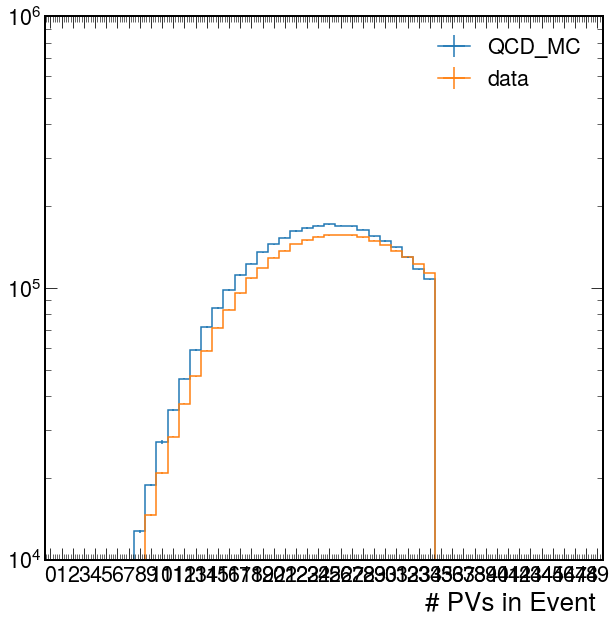

<Figure size 720x720 with 0 Axes>

In [28]:
plot_labels = ['PV_npvs_ch']
samples = ['QCD_MC', 'data']
#'SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']

for plot_label in plot_labels:
    for sample in samples: 
        hep.histplot(plots[sample][plot_label][::1j], 
                     yerr=True, label=sample) 
        
    plt.ylim(1e4,1e6)
    plt.xlim(0,50)
    plt.legend()
    plt.yscale("log")
    plt.show()
    plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')

### 2D Plots
Plot some of the 2D histograms for any number of samples in the same plot.<br>
Parameters:<br>
`plot_label`: _str_, which plot to show.<br>
`samples`: _list of str_, which samples to include in the plot.

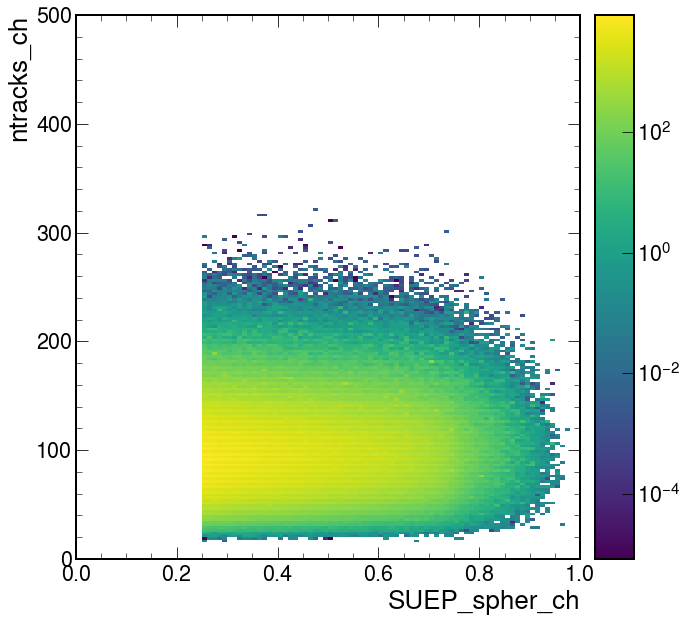

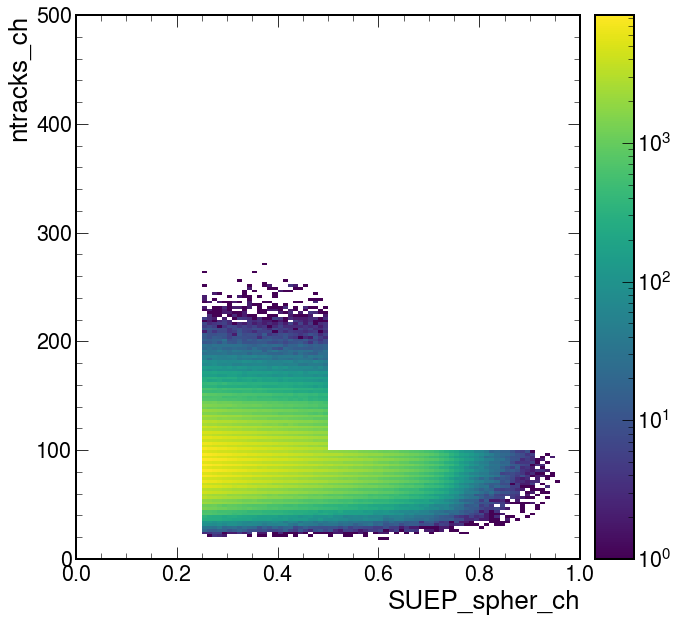

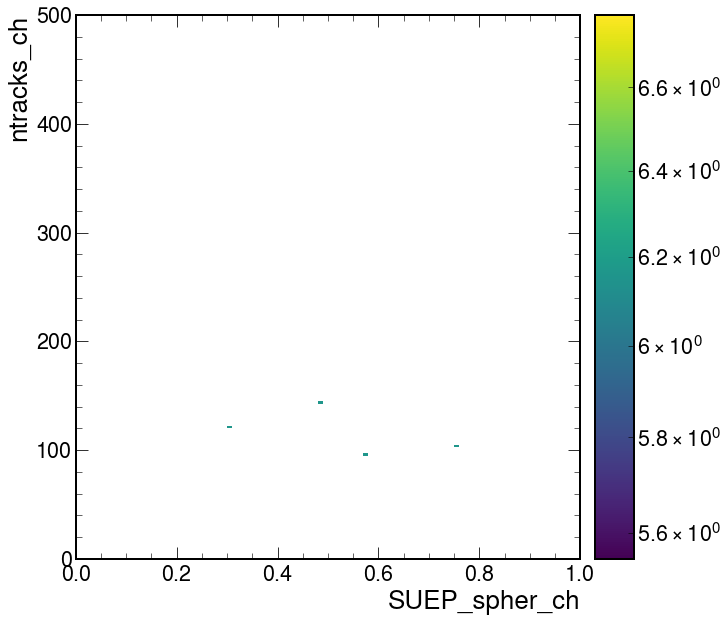

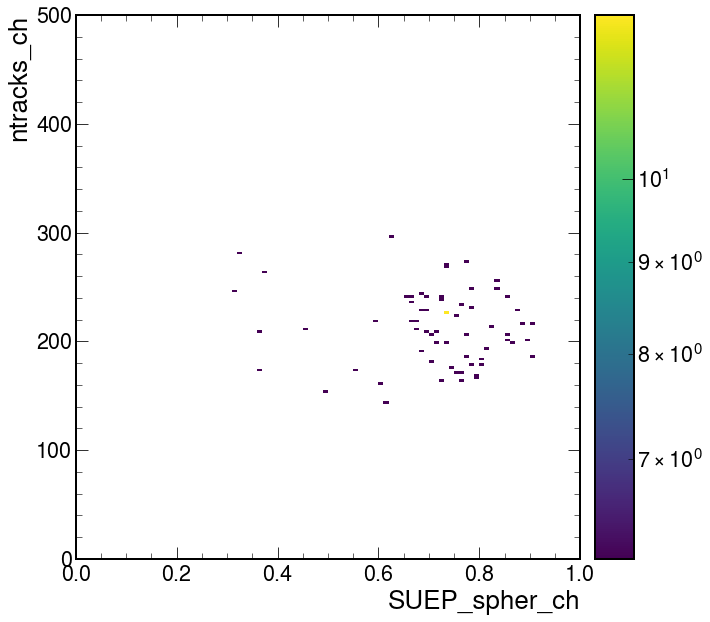

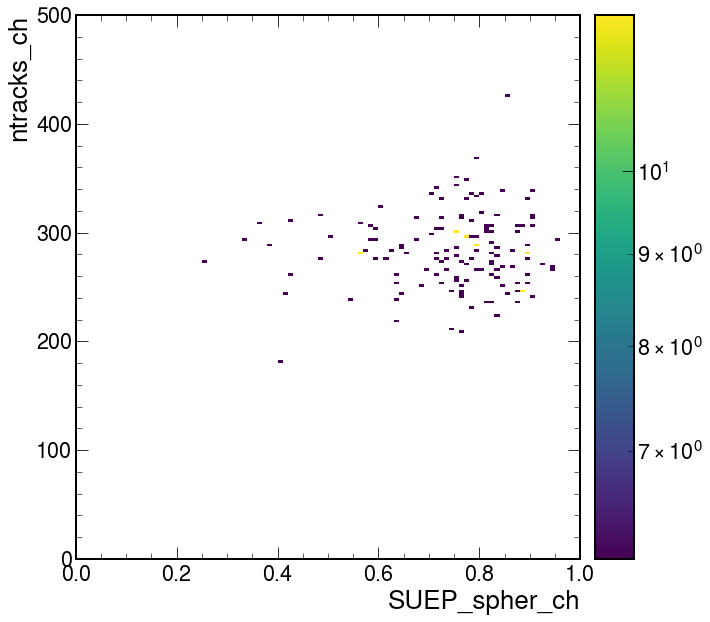

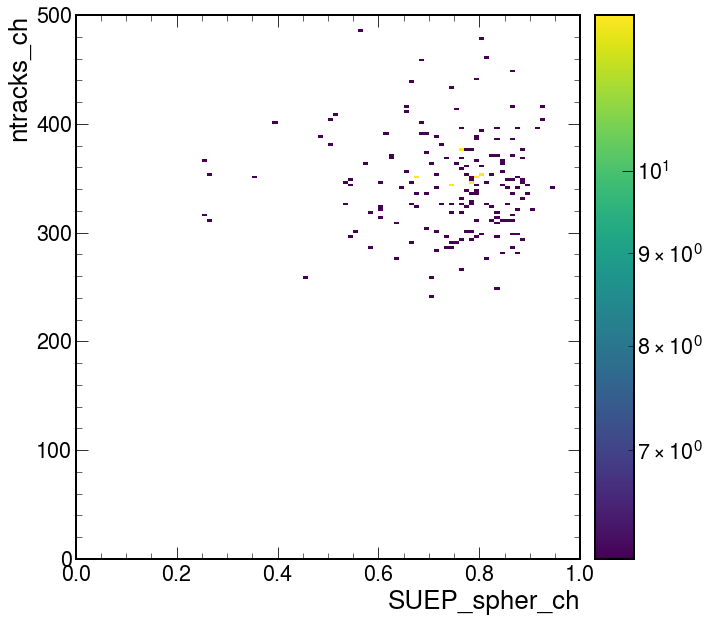

In [6]:
plot_label = '2D_SUEP_spher_ntracks_ch'
samples = ['QCD_MC', 'data',
            'SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
for sample in samples:
    
    if plots[sample][plot_label].sum().value == 0:
        print("Histogram empty for sample", sample)
        continue

    hep.hist2dplot(plots[sample][plot_label], 
               norm=matplotlib.colors.LogNorm(),
               label=sample) 
    plt.savefig(output_label + plot_label+ "_"+sample+file_ext)
    plt.show()

## Ratio Plots: QCD vs. data
Make ratio plots of QCd vs. data.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`plot_labels`: _list of str_, which plots to make.

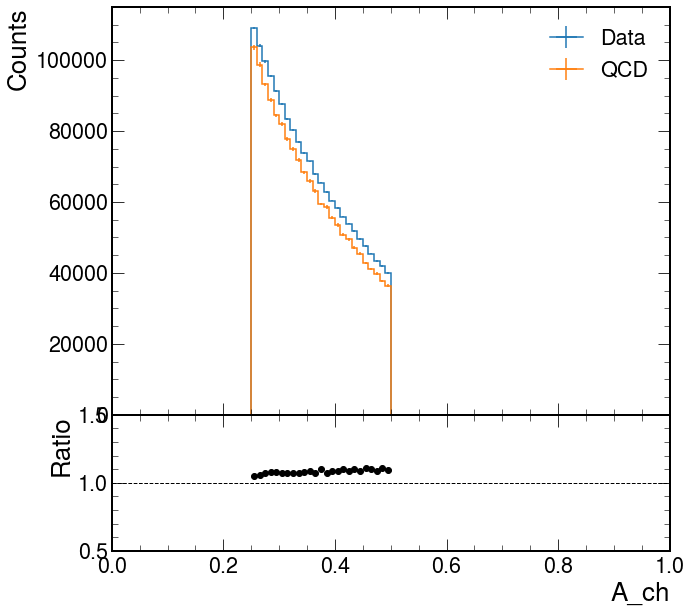

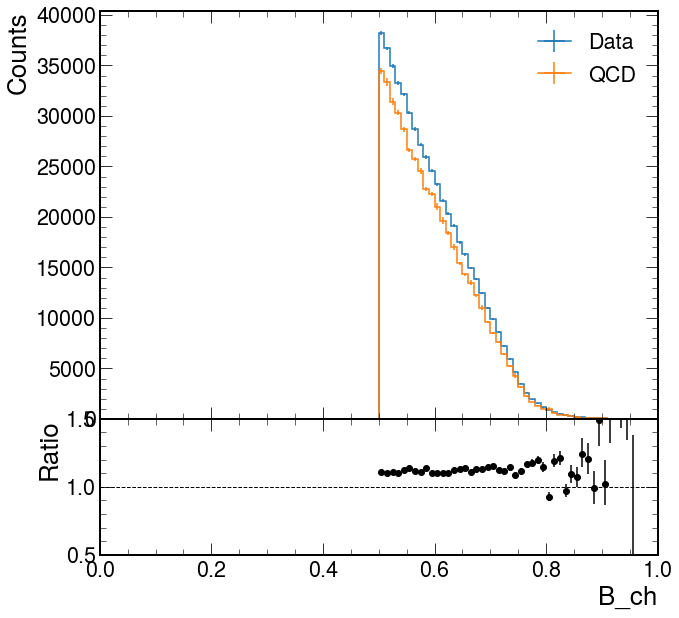

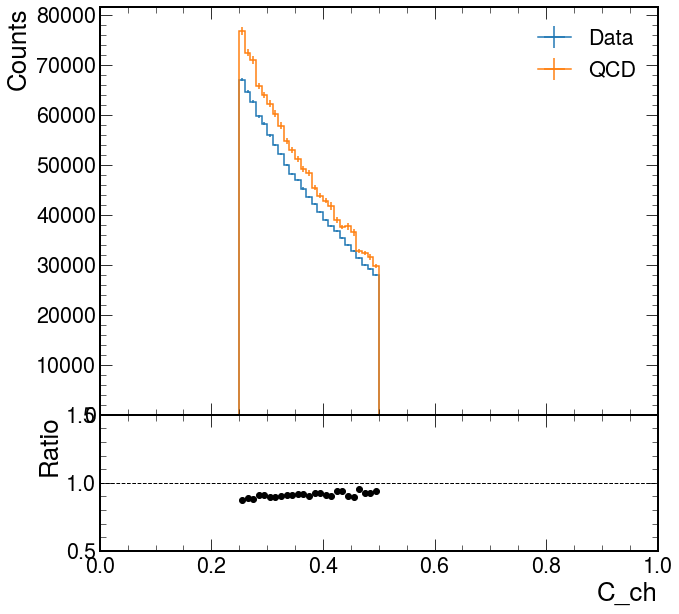

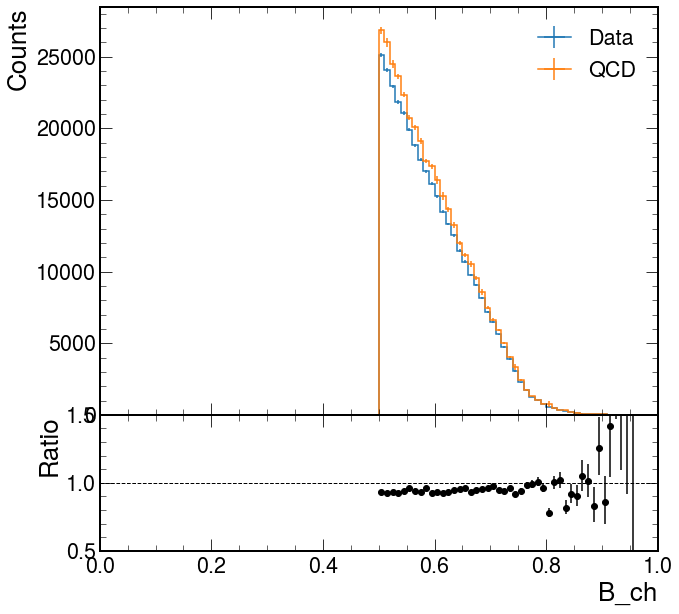

In [7]:
selection = 'ch'
plot_labels = ['A','B','C','D_exp']

for plot_label in plot_labels:
    
    plot_label += '_'+selection

    # QCD hist for ABCD region
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label]
        
    _ = hdata.plot_ratio(hQCD_MC,
                     rp_num_label='Data',
                     rp_denom_label='QCD')
 
    plt.ylim(0.5,1.5)
    plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
    plt.show()

## Ratio Plots: QCD D Region Closure
Make ratio plots to check ABCD closure in the D region.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>

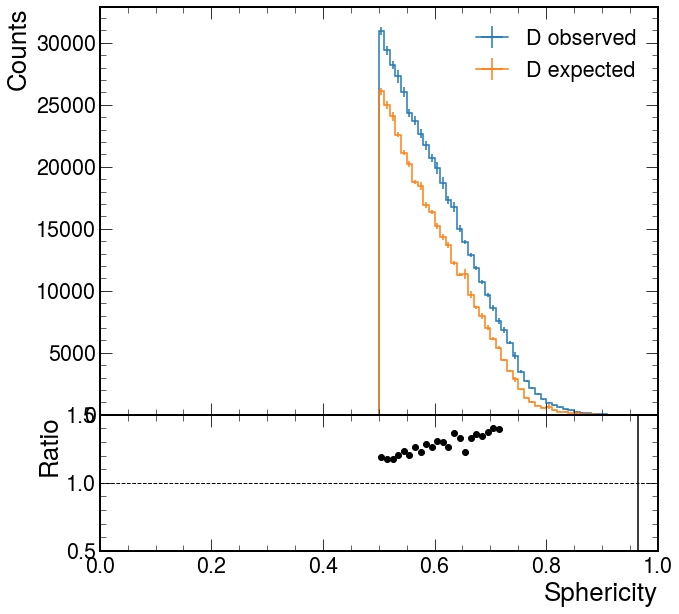

In [19]:
hQCD_MC_D_obs = plots['QCD_MC']['D_obs_ch']
hQCD_MC_D_exp = plots['QCD_MC']['D_exp_ch']

_ = hQCD_MC_D_obs.plot_ratio(hQCD_MC_D_exp,
                 rp_num_label='D observed',
                 rp_denom_label='D expected')

plt.xlabel("Sphericity")
plt.ylim(0.5,1.5)
plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
plt.show()

## Automatic Plotting
Make all plots in the pkl and save them automatically.<br>
For each 1D histogram in the pkl files, it prints a ratio plot for QCD vs. data, and plot with all samples plotted. 2D histograms are plotted separately by sample.

A_ch, 
B_ch, 
C_ch, 
D_exp_ch, 
D_obs_ch, 
A_var2_ch, 
B_var2_ch, 
C_var2_ch, 
D_exp_var2_ch, 
D_obs_var2_ch, 
ABCDvars_2D_ch, Histogram empty for sample SUEP-m1000-generic, 
2D_SUEP_girth_SUEP_nconst_ch, 
2D_SUEP_rho0_SUEP_nconst_ch, 
2D_SUEP_rho1_SUEP_nconst_ch, 
2D_SUEP_spher_ntracks_ch, 
2D_SUEP_spher_SUEP_nconst_ch, 
2D_nJets_SUEP_pT_ch, Histogram empty for sample QCD_MC, Histogram empty for sample data, Histogram empty for sample SUEP-m125-generic, Histogram empty for sample SUEP-m400-generic, Histogram empty for sample SUEP-m750-generic, Histogram empty for sample SUEP-m1000-generic, 
SUEP_nconst_ch, 
SUEP_ntracks_ch, 
SUEP_pt_ch, 
SUEP_pt_avg_ch, 
SUEP_pt_avg_b_ch, One of the histograms is empty, 
SUEP_nLostTracks_ch, 
SUEP_eta_ch, 
SUEP_phi_ch, 
SUEP_mass_ch, 
SUEP_spher_ch, 
SUEP_aplan_ch, One of the histograms is empty, 
SUEP_FW2M_ch, One of the histograms is empty, 
SUEP_D_ch, One of the histograms is empty, 
SUEP_girth, One of the histograms is empty, 
SUEP_rho0_ch, 
SUEP_

KeyboardInterrupt: 

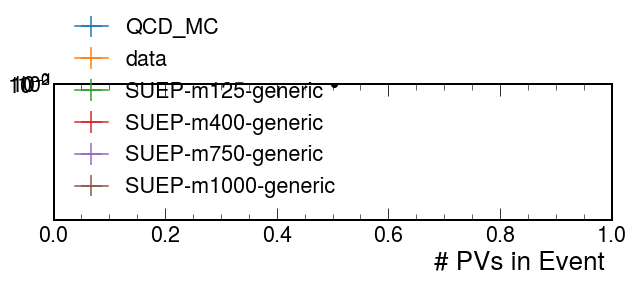

In [19]:
plot_labels = [k for k in list(plots['QCD_MC'].keys())]
if not os.path.isdir(output_label+'allplots/'): os.system("mkdir " + str(output_label+'allplots/'))

for plot_label in plot_labels:
        
    print(plot_label, end=", ")
    
    # 2D plots
    if '2D' in plot_label:
        
        for sample in ['QCD_MC', 'data',
                   'SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']:

            if plots[sample][plot_label].sum().value == 0:
                print("Histogram empty for sample", sample, end=", ")
                continue

            hep.hist2dplot(plots[sample][plot_label], 
                       norm=matplotlib.colors.LogNorm(),
                       label=sample) 
            plt.savefig(output_label + 'allplots/' + plot_label+ "_"+sample+file_ext)
            plt.clf()
        
        
    # 1D variables
    elif '2D' not in plot_label:
        
        # ratio plot
        if "D_obs" not in plot_label:
            try:
                hQCD_MC = plots['QCD_MC'][plot_label]
                hdata = plots['data'][plot_label]
                _ = hdata.plot_ratio(hQCD_MC,
                                 rp_num_label='Data',
                                 rp_denom_label='QCD')
                plt.ylim(-1.0,1.0)
                plt.savefig(output_label + 'allplots/' + plot_label+ "_closure"+file_ext)
                plt.clf()
            except:
                print("One of the histograms is empty", end=", ")

        # plot everything
        for sample in ['QCD_MC', 'data',
                       'SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']:
            hep.histplot(plots[sample][plot_label], yerr=True, label=sample) 
        plt.legend()
        plt.yscale("log")
        plt.savefig(output_label + 'allplots/' + plot_label+ "_all"+file_ext)
        plt.clf()
    print()
print("All done")

## ABCD Independent Variables Check
1D slices of 2D plots, usually used to check the independence of the ABCD method's two variables on the QCD sample. This won't work if QCD has been binned by pt. <br>
N.B.: Imaginary numbers are used to access the bin value; using real numbers would access the bin number (see hist documentation for more info).<br>
Parameters:<br>
`plot_label`:_str_, which plot to analyze.<br>
`sample`: _str_, which sample to analyze.<br>
`slice_label`: _str_, variable being sliced, used in the plot legend.<br>
`slices`: _list of lists of floats_, bins of values to be sliced. e.g. for equal slices use np.linspace(start, end, number of bins), if not can specify as [[0,10],[20,40],[40,50],...].

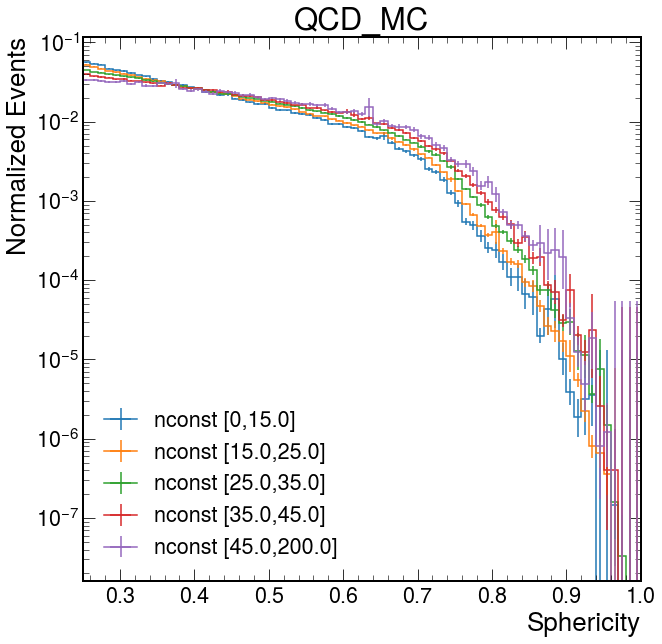

In [43]:
# parameters
plot_label = '2D_SUEP_spher_SUEP_nconst_ch'
sample = 'QCD_MC'
slice_label = 'nconst'            
slices = [[0,15j],[15j,25j],[25j,35j],[35j,45j],[45j,200j]]
#slices = [[0,40j],[40j,80j],[80j,120j],[120j,160j],[160j,500j]]
for i in range(len(slices)):
    val_lo = slices[i][0]
    val_up = slices[i][1]
    
    h = plots[sample][plot_label][:,val_lo:val_up:sum]
            
    hep.histplot(h,
                 yerr=True, density=True, 
                 label=slice_label+" [{0},{1}]".format(val_lo.imag, val_up.imag))    

plt.legend()
plt.title(sample)
plt.xlim(0.25,1.0)
plt.yscale('log')
plt.ylabel("Normalized Events")
plt.xlabel("Sphericity")
plt.savefig(output_label + plot_label + "_1D_SLICES_" + file_ext,  bbox_inches='tight')

## Binned QCD Plots
Make plots with the QCD separated by bins. This won't work if QCD has been marged. <br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`plot_labels`: _list_, which plots you want to make.<br>
`identifier`: _str_, how to identify the QCD samples, e.g. QCD_HT or QCD_Pt.

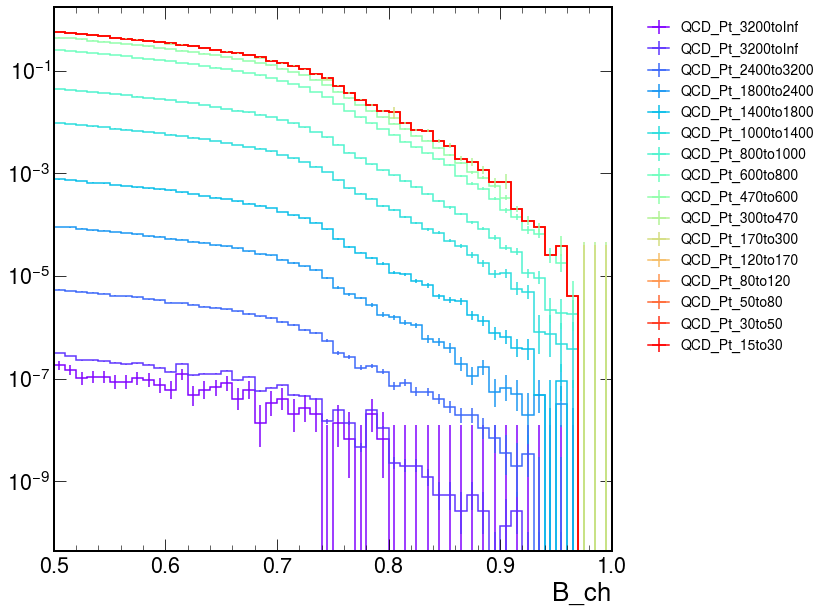

In [58]:
selection = 'ch'
plot_labels = ['B']
identifier = 'QCD_Pt'

for plot_label in plot_labels:
    
    plot_label += "_"+selection

    # get hists
    hlist, labels = [], []
    for key in plots.keys():
        if identifier in key:
            hlist.append(plots[key][plot_label])
            key = key.split('_Tune')[0]
            labels.append(key)
            
    # not sure why, but they NEED to be color coded appropriately
    vals = []
    for key in labels:
        keyslice = key.split(identifier+"_")[1]
        keyslice = keyslice.split("to")[0]
        val = int(keyslice)
        vals.append(val)
    hlist_sorted, labels_sorted = [], []
    for arg in np.argsort(vals)[::-1]:
        hlist_sorted.append(hlist[arg])
        labels_sorted.append(labels[arg])
        
    cmap = plt.cm.rainbow(np.linspace(0, 1, len(labels_sorted)))
        
    hep.histplot(hlist_sorted, stack=True, label=labels_sorted, color=cmap)
    
plt.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlim(0.5,1.0)
plt.yscale("log")
plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')

## Calculate Yields
Integrate histograms to calculate yields.<br>
Parameters:<br>
`lumi`: _float_, scales MC data.<br>
`plot_label`: _str_, which plot you want to integrate.

In [74]:
plot_label = 'PV_npvs_ch'
samples = ['SUEP-m125-generic', 'SUEP-m400-generic',
           'SUEP-m750-generic', 'SUEP-m1000-generic']

for sample in samples:
    h = plots[sample][plot_label]
    passing = h[0j:40j].sum().value
    total = h.sum().value
    print(sample, round(passing/total, 3))

SUEP-m125-generic 1.0
SUEP-m400-generic 1.0
SUEP-m750-generic 1.0
SUEP-m1000-generic 1.0


## Table

Make comparison table by running next cells. The output is meant to be in Latex format.

In [67]:
selection = 'ch'

for plot_label in ['A','B','C','D_exp']:
    
    plot_label+="_"+selection
    
    # QCD hist for ABCD region
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label]
        
    # fill these up for the table
    stats['data'][plot_label]["value"] = hdata.sum().value
    stats['data'][plot_label]["err"] = hdata.sum().variance
    stats['QCD_MC'][plot_label]["value"] = hQCD_MC.sum().value
    stats['QCD_MC'][plot_label]["err"] = hQCD_MC.sum().variance

In [ ]:
table = []
for i in range(len(list(stats.keys()))):
    label = list(stats.keys())[i]
    line = []
    line.append(label)
    
    for r in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        if 'QCD_MC' in label:
            line.append("{:0.0f} ".format(stats[label][r]['value']) + r'$\pm$' + " {:0.0f}".format(stats[label][r]['err']))
        else:
            line.append("{:0.2f} ".format(stats[label][r]['value']) + r'$\pm$' + " {:0.2f}".format(stats[label][r]['err']))
        
    if 'QCD_MC' in label:
        line.append(round((stats[label]['D_exp_'+selection]['value']-stats[label]['D_obs_'+selection]['value'])/stats[label]['D_exp_'+selection]['value'],2))
        line.append(0)
    else:
        line.append(0)
        line.append(stats[label]['D_obs_'+selection]['value']/math.sqrt(stats[label]['D_obs_'+selection]['value']+stats[label]['D_exp_'+selection]['value']+stats[label]['D_obs_'+selection]['err']+stats['QCD_MC']['D_exp_'+selection]['err']))
    table.append(line)                                                         

In [ ]:
t = tabulate(table,tablefmt ='latex',
               headers=['Process', 'A', 'B', 'C', 'D_{exp}', 'D_{obs}', 'D_{exp}-D_{obs}/D_{exp}', 'S/$\sqrt(S+B+\sigma_{S}+\sigma_{B}$)'])
with open('table.txt', 'w') as f:
    f.write(t)
t

In [ ]:
def convert2LatexString(s):
    r = r'(\^\{\})'; s = re.sub(r, "^", s)
    s = re.sub(r'\\([\$\_\{\}\^])', r'\1', s)
    s = re.sub(r'(\\textbackslash{})', r'\\', s)
    return s

t = convert2LatexString(t)
with open('table.txt', 'w') as f:
    f.write(t)
t